In [2]:
# My imports

%matplotlib inline

import nltk
import pickle
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk import tokenize, FreqDist
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
reviews = pd.read_csv('/data/imdb-reviews-pt-br.csv')

In [4]:
reviews.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [5]:
print('This is a negative review:\n\n', reviews.text_pt[0])

This is a negative review:

 Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar um

In [6]:
reviews.sentiment.unique()

array(['neg', 'pos'], dtype=object)

In [7]:
reviews.sentiment.value_counts()

neg    24765
pos    24694
Name: sentiment, dtype: int64

In [8]:
reviews['binary_sentiment_repres'] = reviews.sentiment.replace(['neg', 'pos'], [0,1])
reviews.head()

,id,text_en,text_pt,sentiment,binary_sentiment_repres
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


In [9]:
vectorizer = CountVectorizer(max_features=100)

In [10]:
# If you want to put everything on a sparse DataFrame, but is not a good idea!
# bow = vectorizer.fit_transform(reviews.text_pt)
# df_bow = pd.DataFrame.sparse.from_spmatrix(bow, columns=vectorizer.get_feature_names())

In [11]:
whiteSpaceTokenizer = tokenize.WhitespaceTokenizer()

def get_occurs_df(column):
    all_words = ' '.join([item for item in reviews[column]])
    review_tokens = whiteSpaceTokenizer.tokenize(all_words)
    occurencies = FreqDist(review_tokens)
    return pd.DataFrame({
        'words': list(occurencies.keys()), 
        'occur': list(occurencies.values())
    })

In [12]:
def plot_samples(df, n=10):
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=df.nlargest(columns='occur', n=n), x="words", y="occur", color='green')
    ax.set(ylabel='Count')
    plt.show()

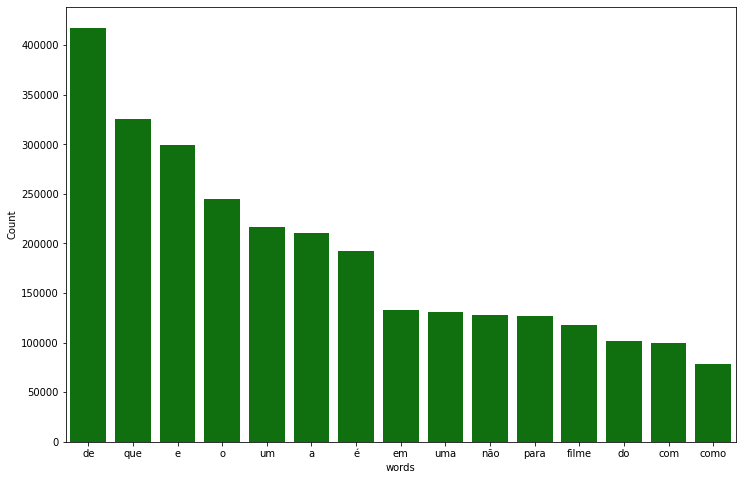

In [13]:
df_occur = get_occurs_df('text_pt')
plot_samples(df_occur, n=15)

In [14]:
nltk.download('stopwords')
irrelevants = stopwords.words("portuguese")

processed_sentece = list()
for each in reviews.text_pt:
    filtered_sentence = list()
    wordish = whiteSpaceTokenizer.tokenize(each)
    for item in wordish:
        if item not in irrelevants:
            filtered_sentence.append(item)
    processed_sentece.append(' '.join(filtered_sentence))

reviews['preprocess_1'] = processed_sentece    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
reviews.head()

,id,text_en,text_pt,sentiment,binary_sentiment_repres,preprocess_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve..."


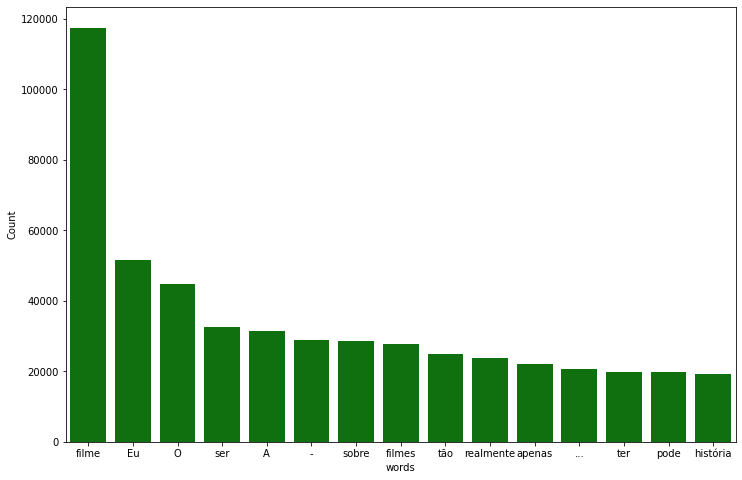

In [16]:
df_occur = get_occurs_df('preprocess_1')
plot_samples(df_occur, n=15)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

bow = vectorizer.fit_transform(reviews.preprocess_1)
print("Bag of words shape", bow.shape)

trX, teX, trY, teY = train_test_split(bow, reviews.binary_sentiment_repres.values.reshape(-1, 1), random_state=9)
print("Train and Test X shapes:", trX.shape, teX.shape)
print("Train and Test Y shapes:", trY.shape, teY.shape)

regressor = LogisticRegression(solver="lbfgs")
regressor.fit(trX, trY.ravel())
print("acc:", regressor.score(teX, teY.ravel()))

Bag of words shape (49459, 100)
Train and Test X shapes: (37094, 100) (12365, 100)
Train and Test Y shapes: (37094, 1) (12365, 1)
acc: 0.7078042862919531


In [18]:
def make_a_prediction(phrase):
    return 'Positive' if regressor.predict(vectorizer.transform([phrase])) else 'Negative'

In [ ]:
#while True:
#    phrase = input('Digite o que achou do Filme "De volta para o Futuro": ')
#    print(make_a_prediction(phrase))

## Persistindo os dados para usar na API

De

https://scikit-learn.org/stable/modules/model_persistence.html#persistence-example

In [ ]:
from joblib import dump, load
dump(regressor, 'sklearn-logistc-regressor-model.joblib') 

In [ ]:
pickle.dump(vectorizer, open("vectorizer.pickle", "wb"))